In [88]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "../../../write/02_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "../../../figures/PICA0001-PICA0007/02_annotation"



In [89]:
raw_adata_cd4= sc.read_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad")
raw_adata_cd4.var_names_make_unique()
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [90]:
raw_adata_cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    9527
Regulatory T cell                   267
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

#### 1. Batch integration with scVI

In [91]:
scvi.model.SCVI.setup_anndata(raw_adata_cd4, layer="counts", batch_key="pica_id")

In [92]:
model = scvi.model.SCVI(raw_adata_cd4, n_layers=2, n_latent=30, gene_likelihood="nb")

In [93]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [2:12:15<00:00, 18.89s/it, v_num=1, train_loss_step=7.79e+3, train_loss_epoch=7.81e+3]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [2:12:15<00:00, 19.84s/it, v_num=1, train_loss_step=7.79e+3, train_loss_epoch=7.81e+3]


saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/umap_scvi_integrated_umap.png


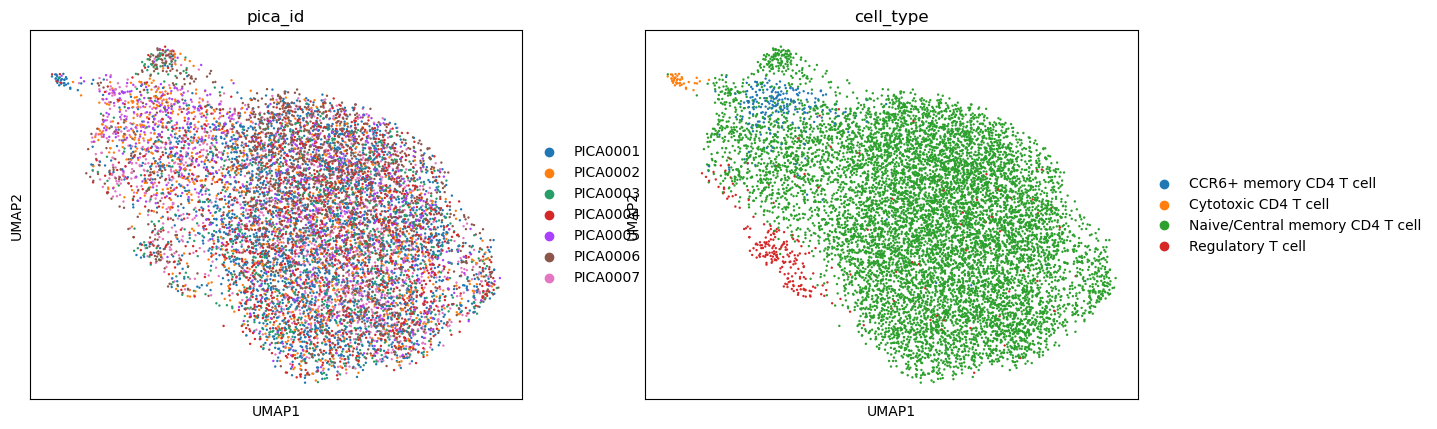

In [94]:
raw_adata_cd4.obsm["X_scVI"] = model.get_latent_representation()

#  latent representation 
sc.pp.neighbors(raw_adata_cd4, use_rep="X_scVI")
sc.tl.umap(raw_adata_cd4)


sc.pl.umap(raw_adata_cd4, color=[ "pica_id", 'cell_type'], save="_scvi_integrated_umap.png")

saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/umap_scvi_qc.png


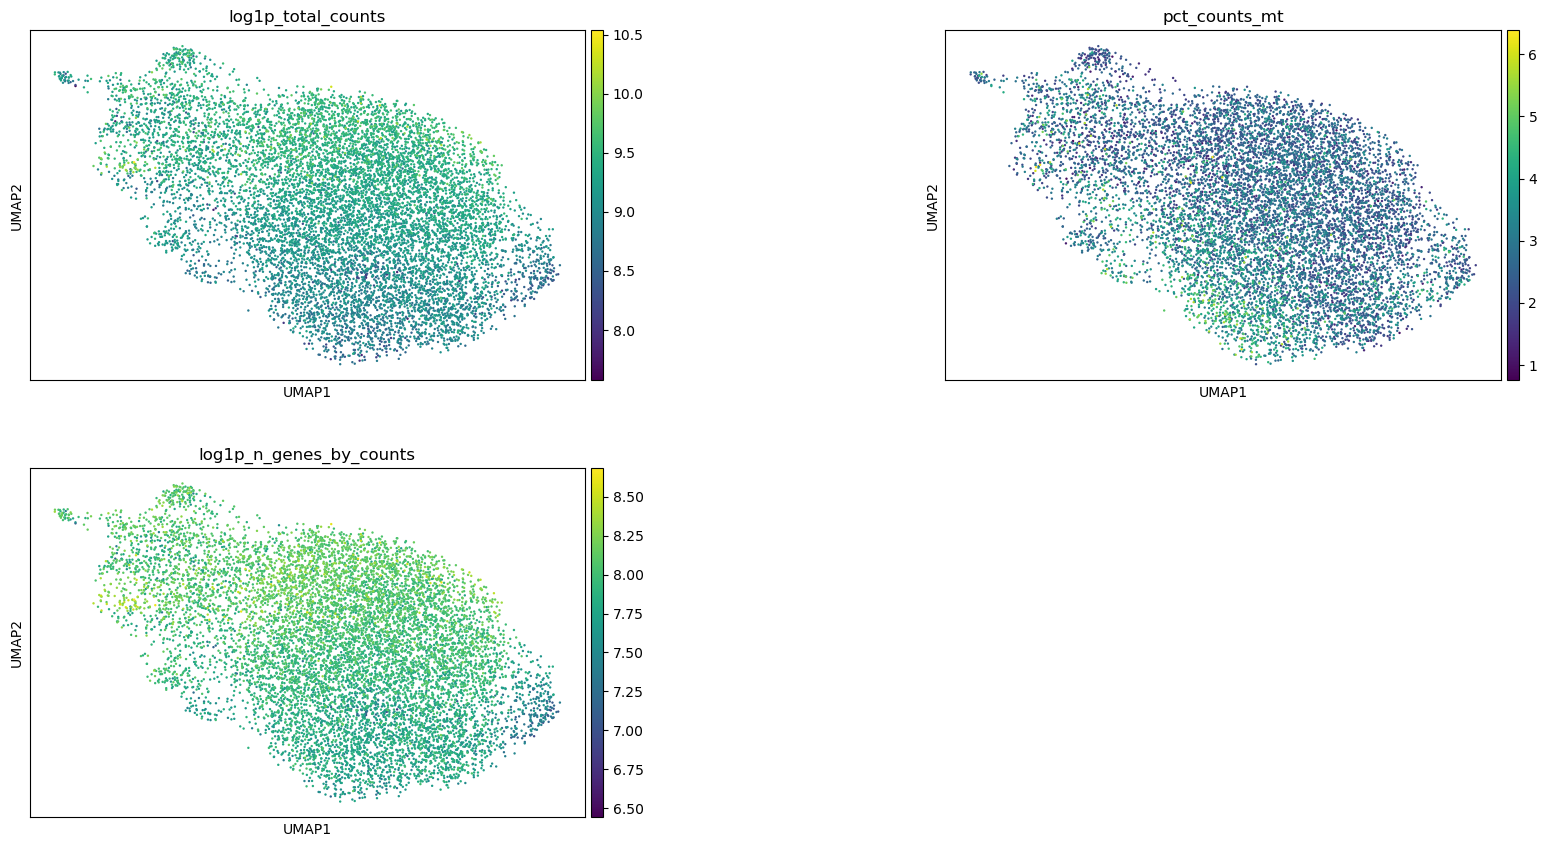

In [95]:
sc.pl.umap(
    raw_adata_cd4,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save="_scvi_qc.png"
)

In [96]:
# Save the scVI integrated batch adata
raw_adata_cd4.write_h5ad("../../../write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI.h5ad", compression='gzip')

#### 2. Clustering
- resolutions
- known marker genes to see if they align with cluster size

In [97]:
# Test different resolutions for Leiden clustering
# Higher resolution will result in more clusters, lower resolution will result in fewer clusters
for res in [ 0.5, 1.0, 1.5, 2.0]:
    sc.tl.leiden(
        raw_adata_cd4, key_added=f"leiden_res_{res:3.1f}", resolution=res, flavor="igraph"
    )

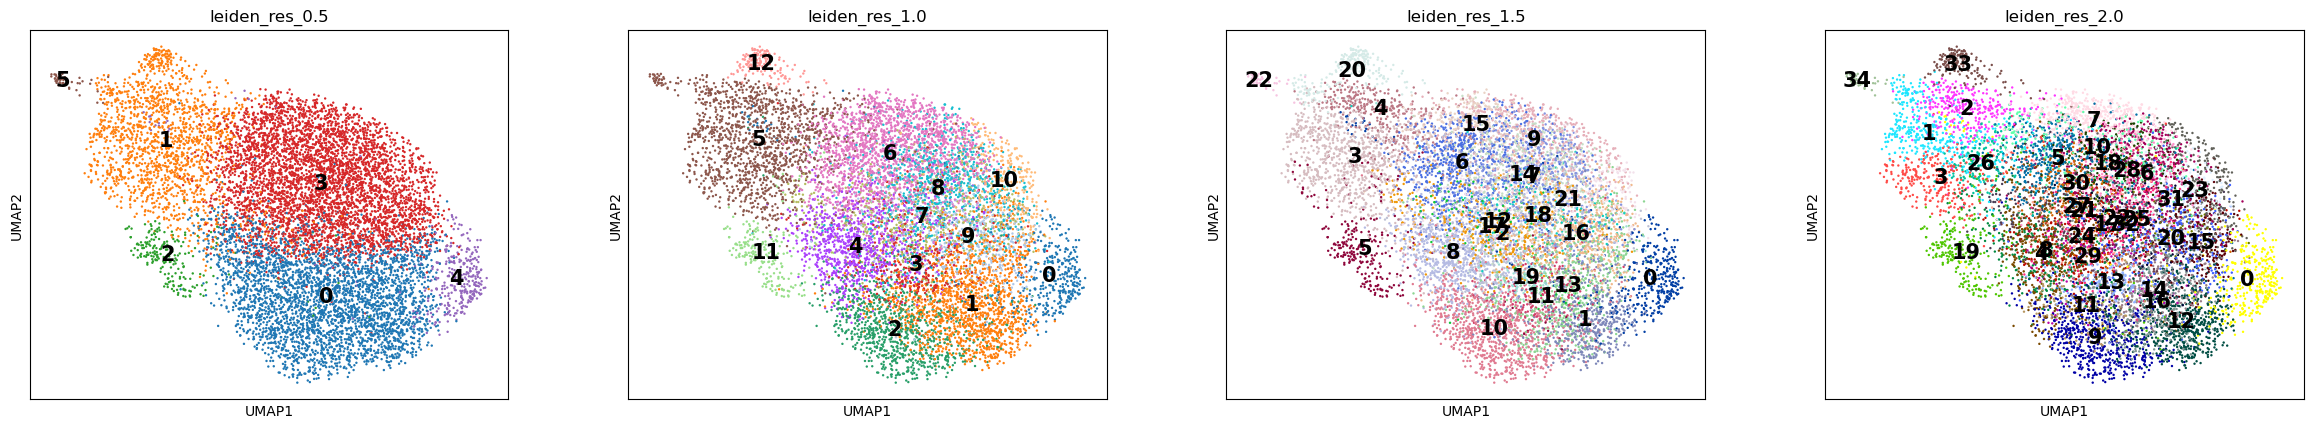

In [98]:
sc.pl.umap(
    raw_adata_cd4,
    color=[ "leiden_res_0.5", "leiden_res_1.0","leiden_res_1.5", "leiden_res_2.0"],
    legend_loc="on data", legend_fontsize = 15
)

In [99]:
# Save the clustered adata
raw_adata_cd4.write_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad", compression='gzip')
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 
'cell_type_colors', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 
'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 'leiden_res_1.5_colors', 'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [100]:
raw_adata_cd4= sc.read_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad")
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_0.5_colors', 
'leiden_res_1.0', 'leiden_res_1.0_colors', 'leiden_res_1.5', 'leiden_res_1.5_colors', 'leiden_res_2.0', 
'leiden_res_2.0_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

##### 3. CD4 subset validation

In [101]:
broad_marker_genes = {
    "B cell": ["BLNK", "CD19", "CD79A", "CD79B", "MS4A1", "CD37", "CD79A"],
    "Plasmablast": ["CD19", "CD24", "CD38"], # experiment
    "Dendritic cell": ["CLEC4C", "IL3RA", "NRP1", "CD1C", "CST3", "FCER1A", "CD123", "GZMB"],
    "Endothelial cell": ["CDH5", "SELE", "VWF"],
    "Fibroblast": ["COL1A1", "COL3A1", "FAP", "THY1"],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],  # CEACAM8 is highly specific neutrophil marker
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],  
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],  
    "Classical monocyte": ["CD14", "FCGR3A", "LYZ", "FCGR1A", 'CCR2', 'S100A8', 'S100A9'], # CD14⁺ CD16/FCGR3A⁻
    "Intermediate monocyte": ["CD14", "FCGR3A", "HLA-DRA", "CCL2", 'ITGAX'], # CD14⁺ CD16⁺
    "Non-classical monocyte": ["CD14", "FCGR3A", "TREML4", "NR4A1", 'CX3CR1', 'HLA-DPB1'], # CD14⁻CD16⁺
    "Natural killer cell": ["CCL3", 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1'],
    "Platelet": ["CD41", "ITGA2B", "CD34", "CD61", "PF4", 'PLA2G12A', 'PPBP'], # No megakaryocyte in blood
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    "T cell": ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    "CD4+ memory T cell": ['CCR7', 'CD27', 'IL7R'],
    "CD4+ T cell": ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    "CD8+ T cell": ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    "Naive T cell": ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    "Natural killer T (NKT) cell": ['CD8A', 'CD8B', 'ZNF683'],
}

In [102]:
adata_full = raw_adata_cd4.raw.to_adata()
adata_full
present_marker_genes = {}

for celltype, markers in broad_marker_genes.items():
    present_markers = []
    for marker in markers:
        if marker in adata_full.var_names:
            present_markers.append(marker)
    present_marker_genes[celltype] = present_markers
print(present_marker_genes)

{
    'B cell': ['BLNK', 'CD19', 'CD79A', 'CD79B', 'MS4A1', 'CD37', 'CD79A'],
    'Plasmablast': ['CD19', 'CD24', 'CD38'],
    'Dendritic cell': ['CLEC4C', 'IL3RA', 'NRP1', 'CD1C', 'CST3', 'FCER1A', 'GZMB'],
    'Endothelial cell': ['CDH5', 'SELE', 'VWF'],
    'Fibroblast': ['COL1A1', 'COL3A1', 'FAP', 'THY1'],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],
    'Classical monocyte': ['CD14', 'FCGR3A', 'LYZ', 'FCGR1A', 'CCR2', 'S100A8', 'S100A9'],
    'Intermediate monocyte': ['CD14', 'FCGR3A', 'HLA-DRA', 'CCL2', 'ITGAX'],
    'Non-classical monocyte': ['CD14', 'FCGR3A', 'TREML4', 'NR4A1', 'CX3CR1', 'HLA-DPB1'],
    'Natural killer cell': [
        'CCL3',
        'CD160',
        'CD247',
        'GNLY',
        'GZMB',
        'NKG7',
        'FCGR3A',
        'FCGR3B',
        'KLRB1',
        'KLRC1',
        'KLRD1',
        'KLRF1',
        'KLRK1',
        'NCAM1'
    ],
    'Platelet': ['ITGA2B', 'CD34', 'PF4', 'PLA2G12A', 'PPBP'],
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    'T cell': ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    'CD4+ memory T cell': ['CCR7', 'CD27', 'IL7R'],
    'CD4+ T cell': ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    'CD8+ T cell': ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    'Naive T cell': ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    'Natural killer T (NKT) cell': ['CD8A', 'CD8B', 'ZNF683']
}

saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/dotplot__all_markers.png


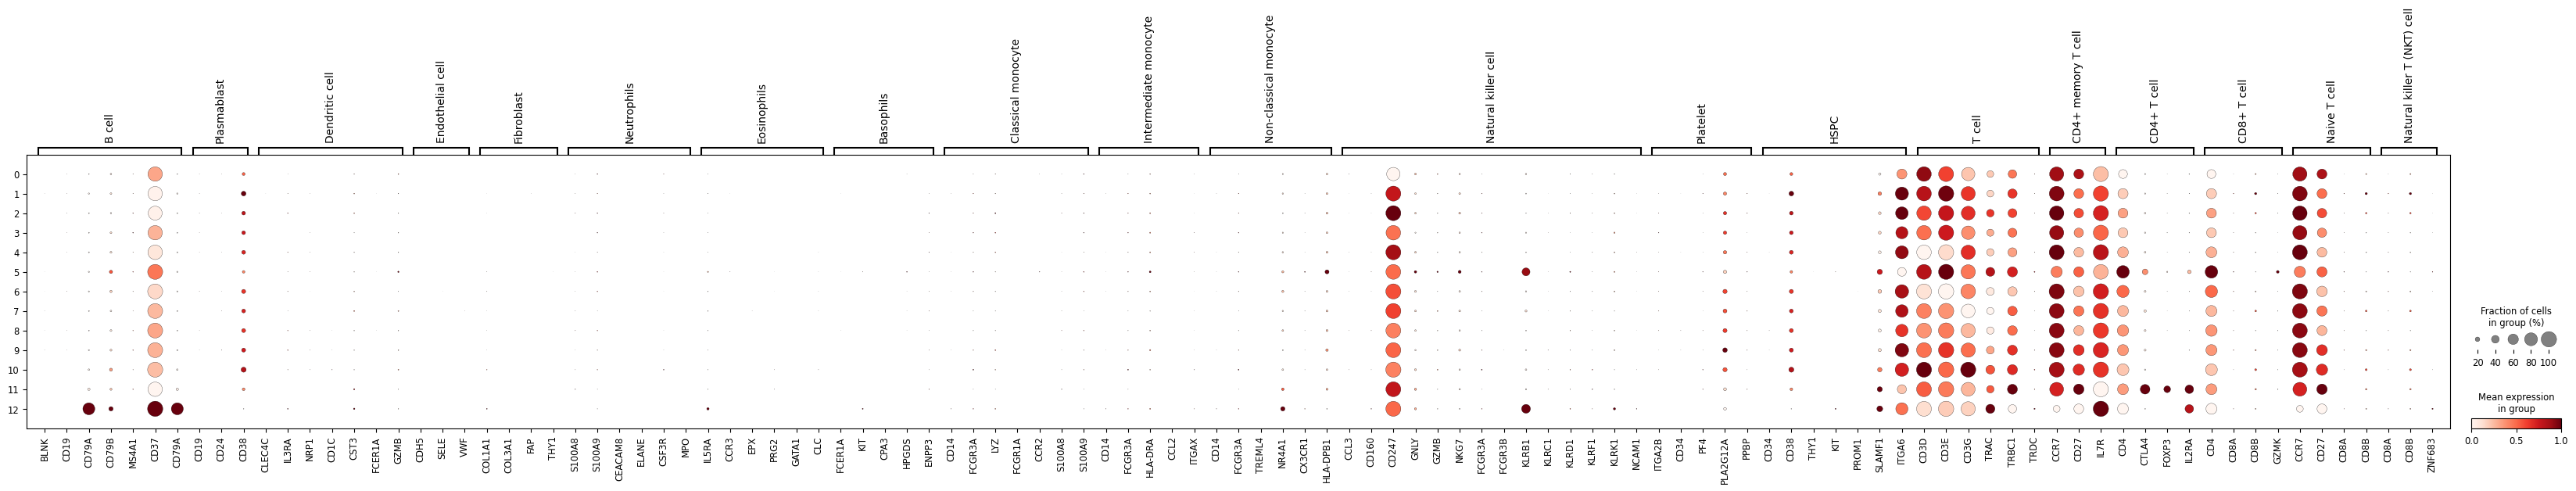

In [103]:
sc.pl.dotplot(raw_adata_cd4, present_marker_genes , groupby="leiden_res_1.0", standard_scale="var", save="_all_markers.png")

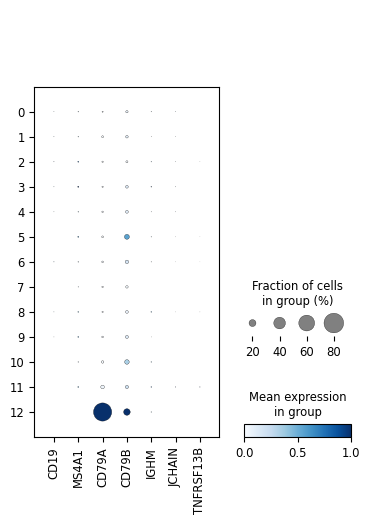

In [104]:
sc.pl.dotplot(raw_adata_cd4, ["CD19", "MS4A1", "CD79A", "CD79B", "IGHM", "JCHAIN", "TNFRSF13B"], groupby="leiden_res_1.0", standard_scale = "var", color_map = "Blues")

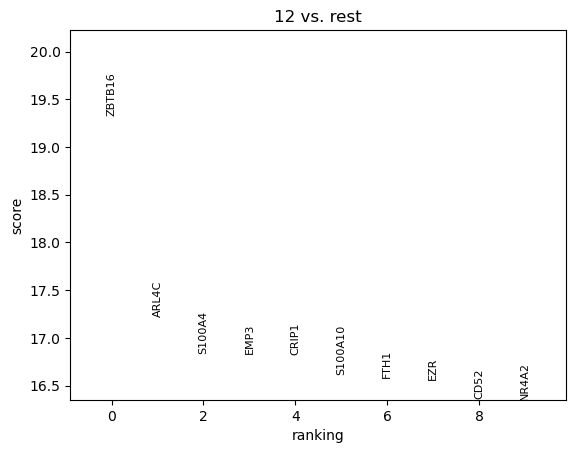

In [105]:
# Cluster 12 looks like B cell
sc.tl.rank_genes_groups(raw_adata_cd4, groupby="leiden_res_1.0", groups=['12'], method="wilcoxon")
sc.pl.rank_genes_groups(raw_adata_cd4, groupby="leiden_res_1.0", n_genes=10)

In [106]:
print(sc.get.rank_genes_groups_df(raw_adata_cd4, group='12').head(30)["names"])

0       ZBTB16
1        ARL4C
2       S100A4
3         EMP3
4        CRIP1
5      S100A10
6         FTH1
7          EZR
8         CD52
9        NR4A2
10       ANXA1
11       AHNAK
12        IL32
13     LRRFIP1
14       CD79A
15         FOS
16       CLIC1
17    SH3BGRL3
18       PRKD3
19         CR1
20       FXYD5
21        TPM3
22        CCR4
23      PIK3R1
24     TAMALIN
25       DUSP1
26      CSRNP1
27        SRGN
28       AUTS2
29      ADAM19
Name: names, dtype: object

saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/umap_cluster12_marker_overlays.png


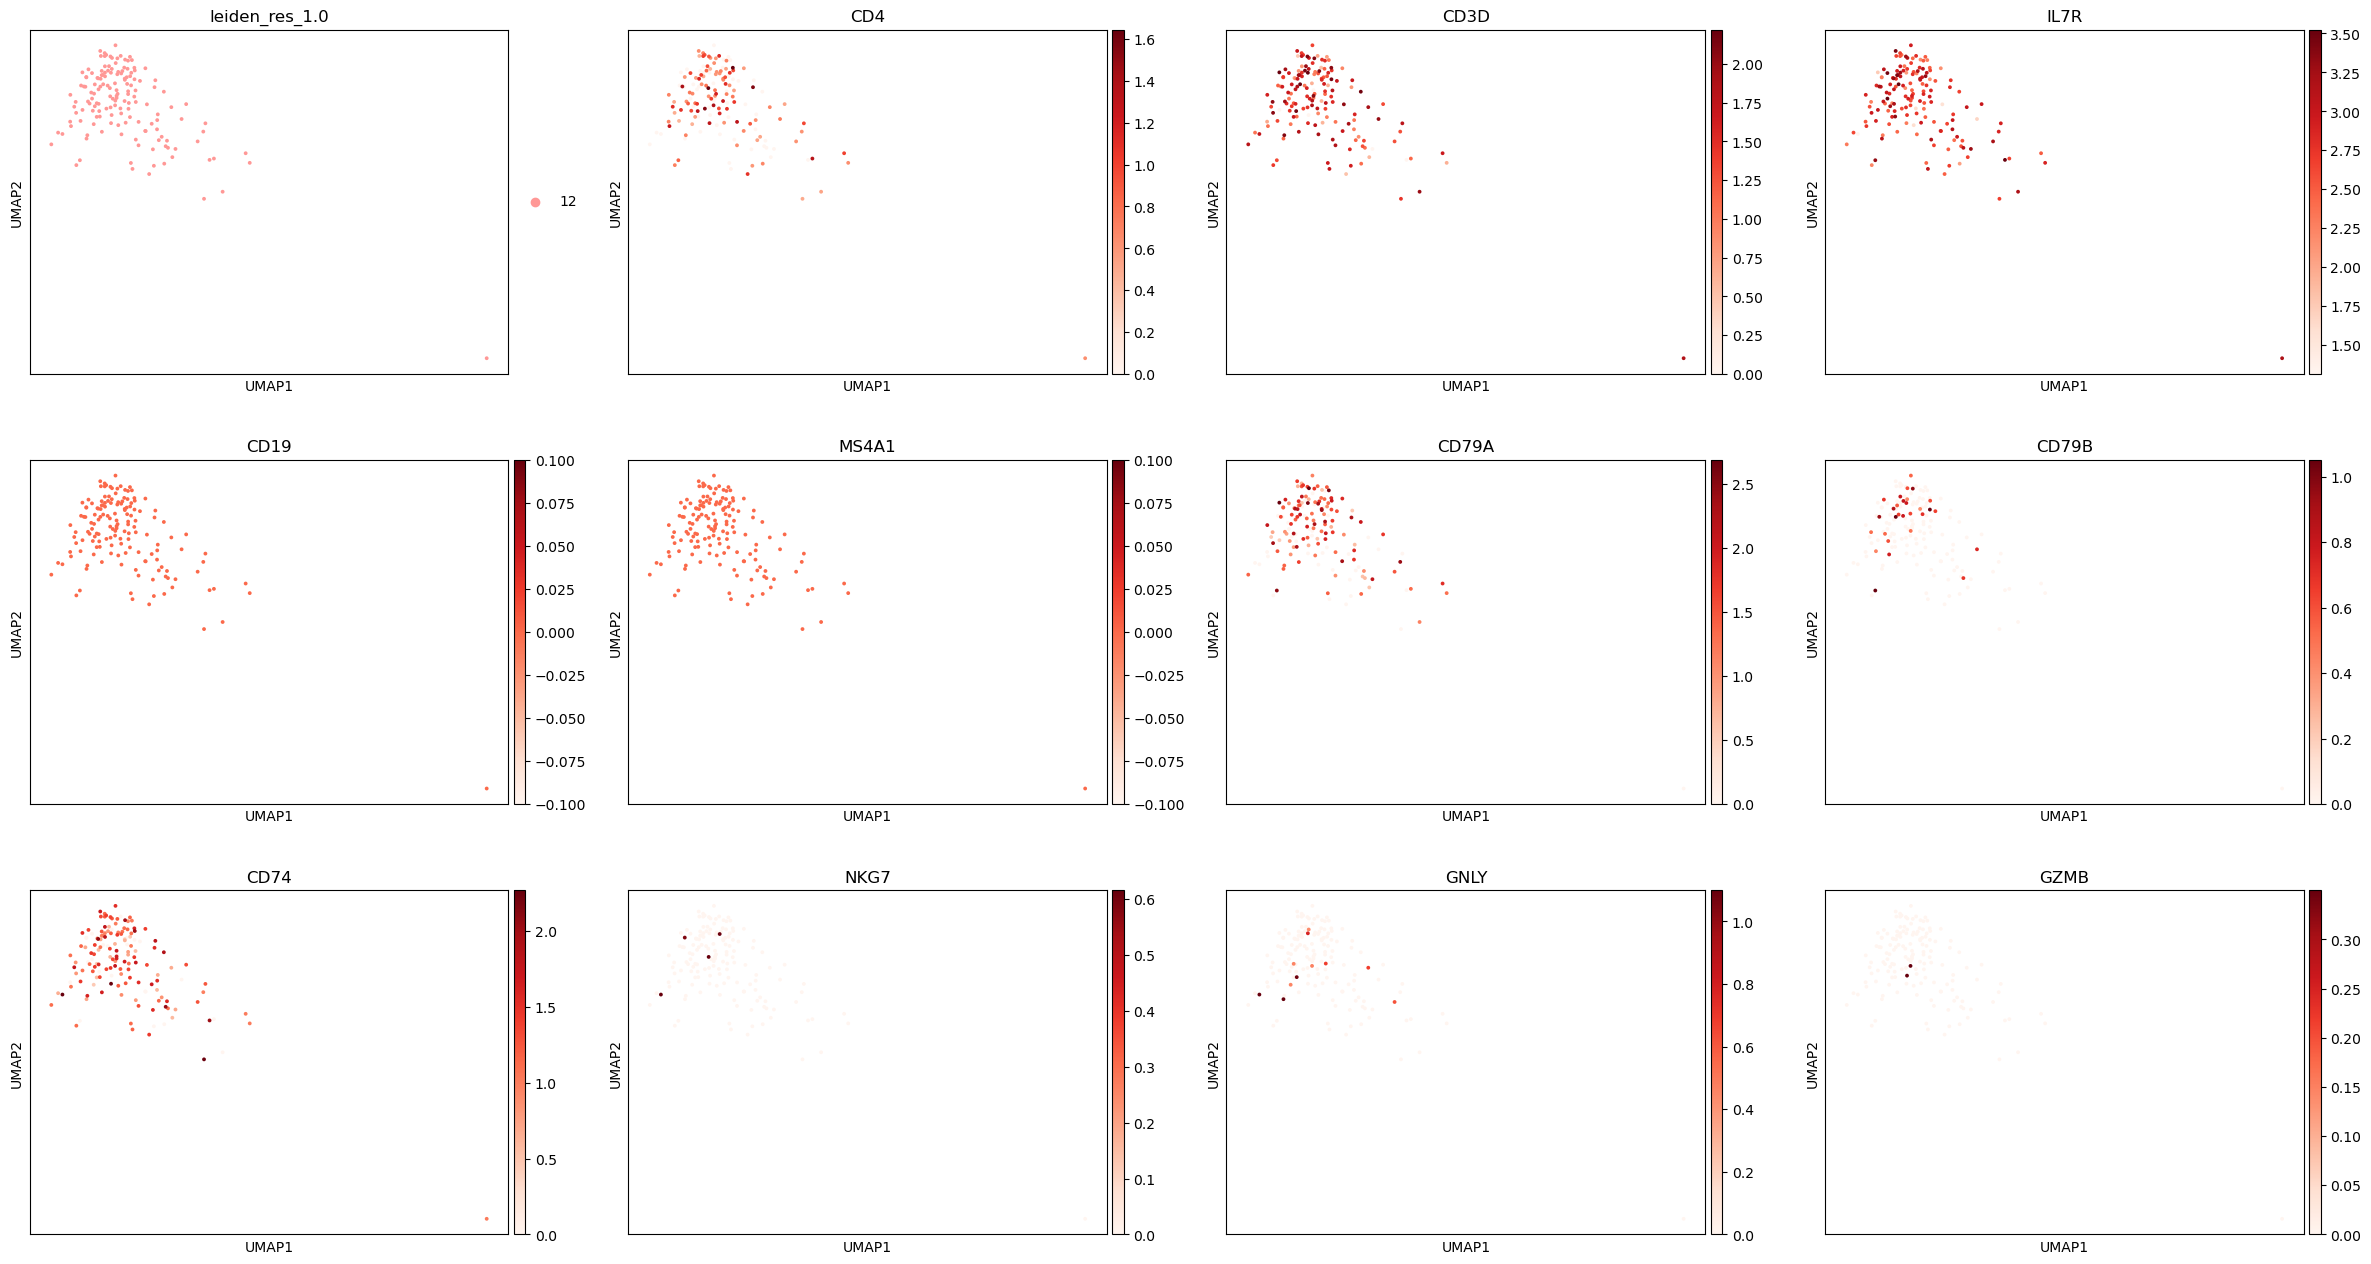

In [107]:
# check core marker expression overlays for cluster 12
cluster_12_cells = raw_adata_cd4[raw_adata_cd4.obs['leiden_res_1.0'] == '12']
sc.pl.umap(
    cluster_12_cells,
    color=["leiden_res_1.0","CD4","CD3D","IL7R",     # CD4 T markers
           'CD19',"MS4A1","CD79A","CD79B","CD74", # B cell markers
           "NKG7","GNLY","GZMB"],   # NK / cytotoxic markers
    vmax="p99",
    cmap="Reds",
    size=30,
    save="_cluster12_marker_overlays.png"
)

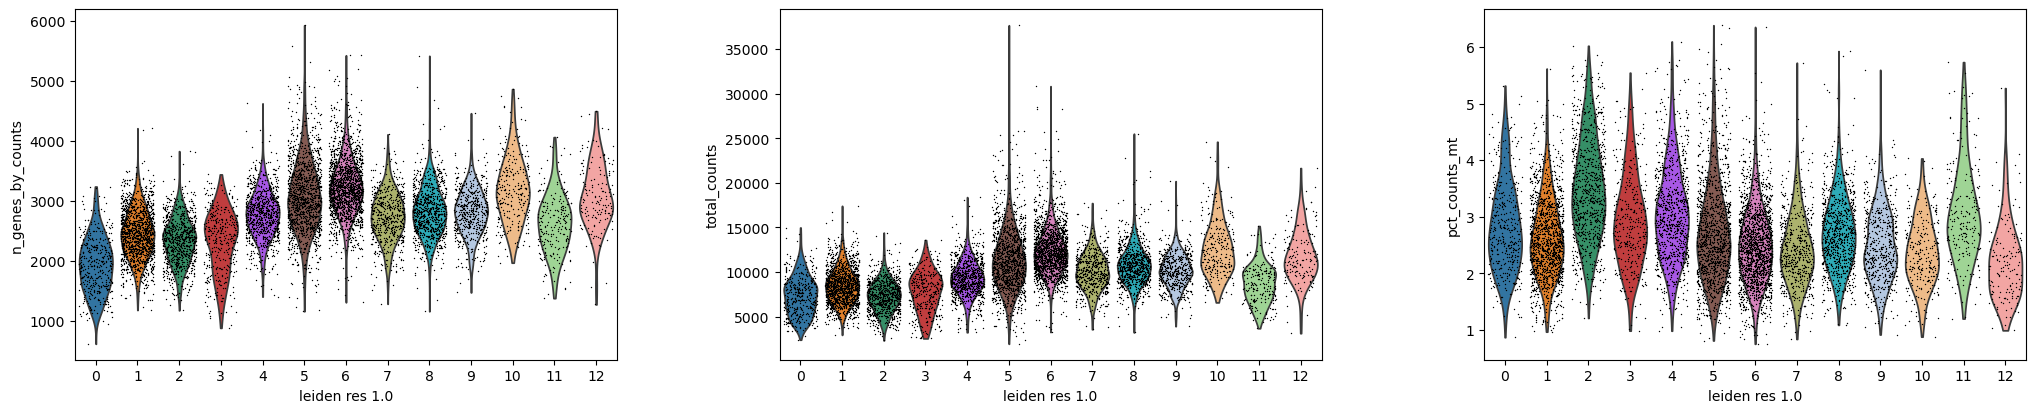

In [108]:
sc.pl.violin(raw_adata_cd4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= 'leiden_res_1.0', jitter=0.4, multi_panel=True)

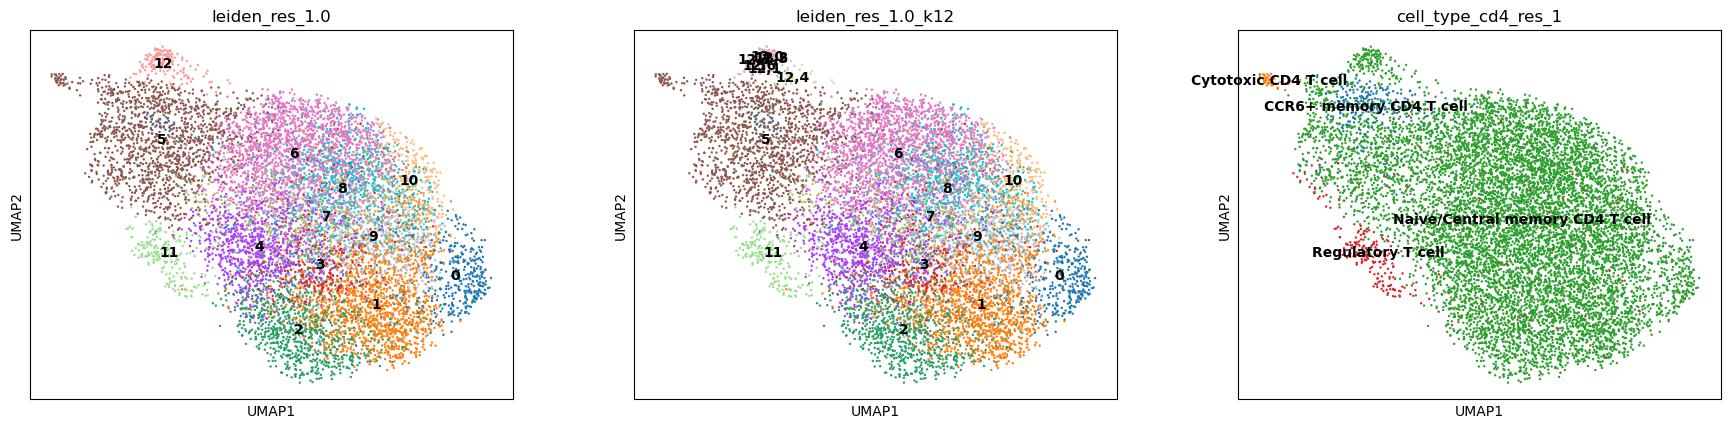

In [109]:
raw_adata_cd4.obs['cell_type_cd4_res_1'] = raw_adata_cd4.obs['cell_type'].copy()
adata_cd4_k12 = raw_adata_cd4.copy()
sc.tl.leiden(adata_cd4_k12, resolution=1.0, restrict_to=('leiden_res_1.0', ['12']), key_added='leiden_res_1.0_k12')
sc.pl.umap(adata_cd4_k12, color=['leiden_res_1.0', 'leiden_res_1.0_k12','cell_type_cd4_res_1'], legend_loc="on data")


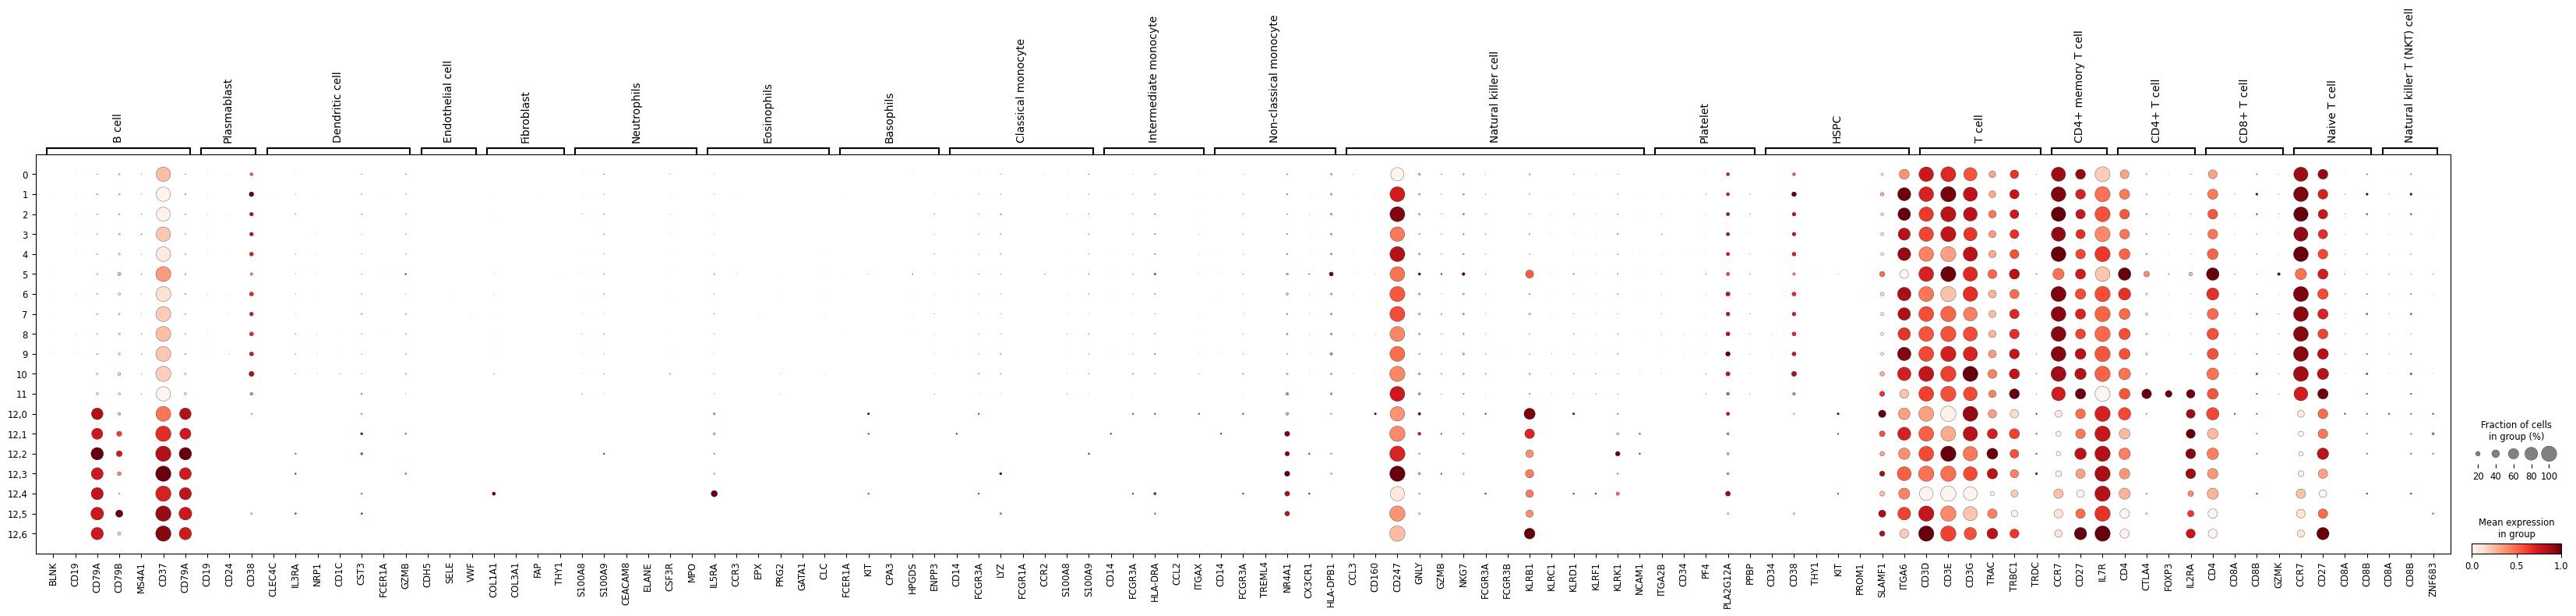

In [110]:
sc.pl.dotplot(adata_cd4_k12, present_marker_genes , groupby="leiden_res_1.0_k12", standard_scale="var")

Cluster 12 exhibited co-expression of canonical B-cell markers (CD79A, CD79B) and pan-T-cell markers (CD3D, CD3E), suggesting the presence of T/B doublets. This hybrid signature, together with its distinct position on the UMAP, indicates technical doublets rather than a true biological subset. Consequently, this cluster was excluded from downstream analysis.

In [111]:
raw_adata_cd4.obs['leiden_res_1.0'] = raw_adata_cd4.obs['leiden_res_1.0'].astype(str)
raw_adata_cd4 = raw_adata_cd4[raw_adata_cd4.obs['leiden_res_1.0'] != '12', :].copy()

In [112]:
raw_adata_cd4.obs['cell_type_cd4_res_1'].value_counts()

cell_type_cd4_res_1
Naive/Central memory CD4 T cell    9373
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

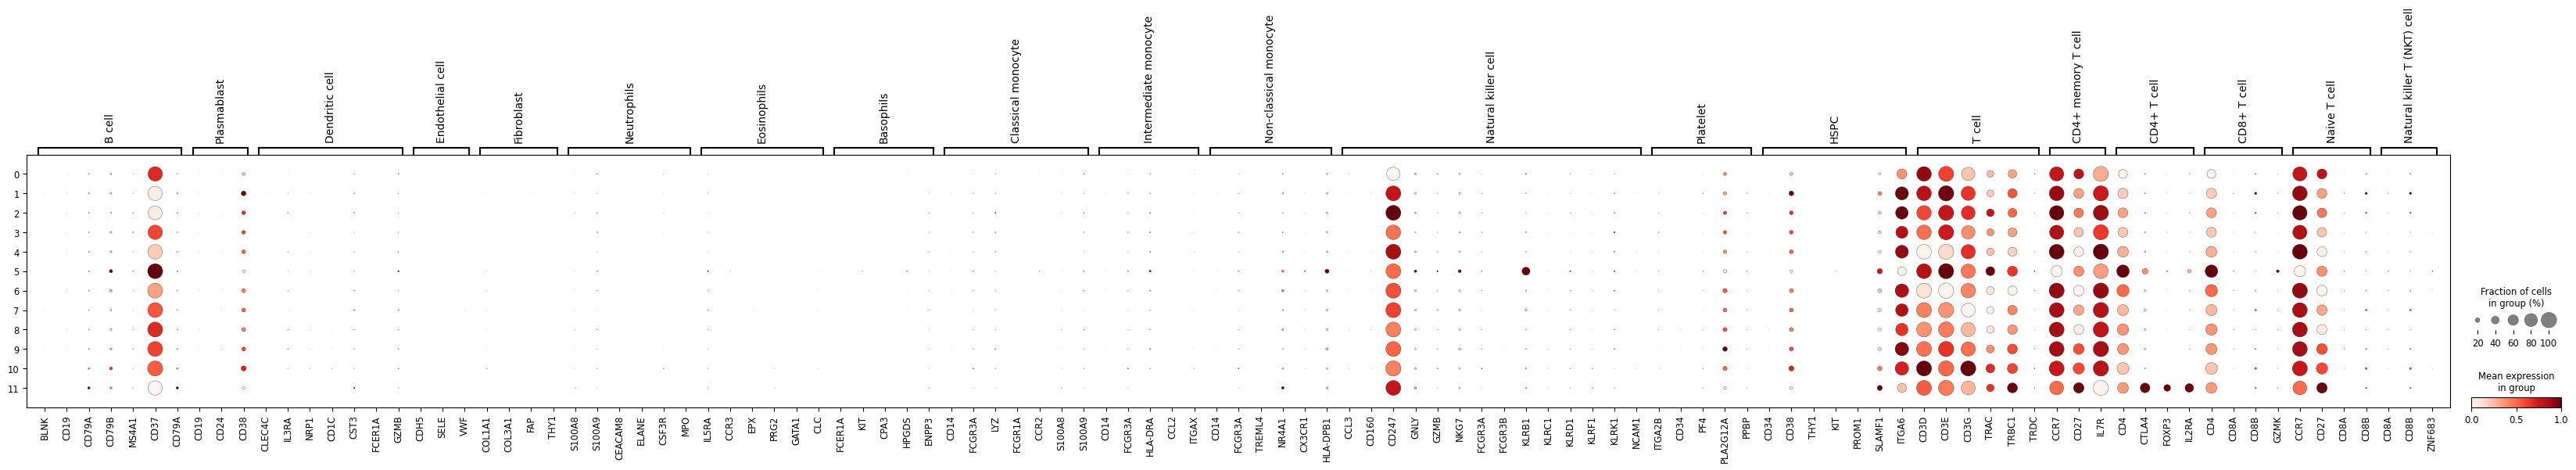

In [113]:
sc.pl.dotplot(raw_adata_cd4,present_marker_genes , groupby="leiden_res_1.0", standard_scale="var")

In [114]:
# save data without cluster 12
raw_adata_cd4.write_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed_2.h5ad", compression='gzip')


In [115]:
adata_cd4= sc.read_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed_2.h5ad")
adata_cd4.var_names_make_unique()
print(adata_cd4)

AnnData object with n_obs × n_vars = 9904 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_0.5_colors', 
'leiden_res_1.0', 'leiden_res_1.0_colors', 'leiden_res_1.5', 'leiden_res_1.5_colors', 'leiden_res_2.0', 
'leiden_res_2.0_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [116]:
# run scvi again
scvi.model.SCVI.setup_anndata(adata_cd4, layer="counts", batch_key="pica_id")
model_clean = scvi.model.SCVI(adata_cd4, n_layers=2, n_latent=30, gene_likelihood="nb")

In [117]:
model_clean.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [2:32:11<00:00, 19.41s/it, v_num=1, train_loss_step=7.9e+3, train_loss_epoch=7.8e+3]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [2:32:11<00:00, 22.83s/it, v_num=1, train_loss_step=7.9e+3, train_loss_epoch=7.8e+3]


saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/umap_scvi_integrated_umap.png


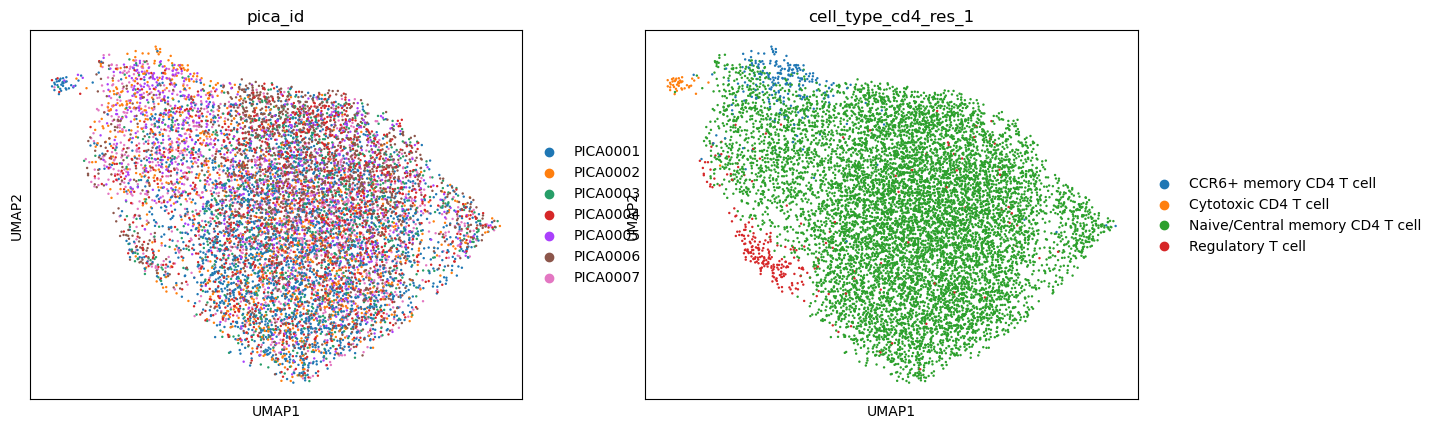

In [118]:
adata_cd4.obsm["X_scVI"] = model_clean.get_latent_representation()

#  latent representation 
sc.pp.neighbors(adata_cd4, use_rep="X_scVI")
sc.tl.umap(adata_cd4)


sc.pl.umap(adata_cd4, color=[ "pica_id", 'cell_type_cd4_res_1'], save="_scvi_integrated_umap.png")

saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/umap_scvi_qc.png


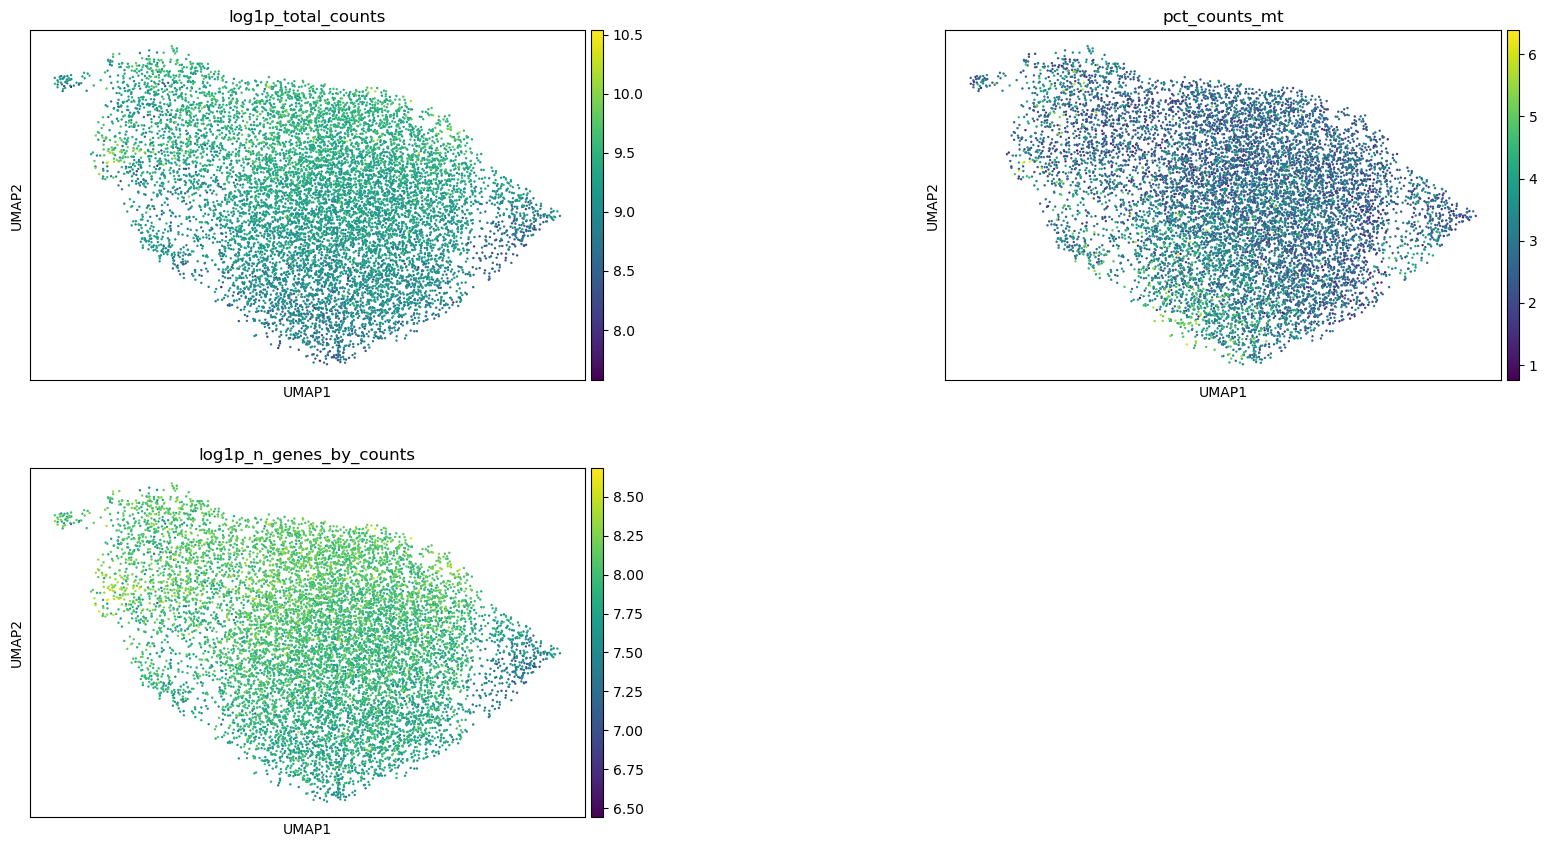

In [119]:
sc.pl.umap(
    adata_cd4,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save="_scvi_qc.png"
)

In [120]:
# Save the scVI integrated batch adata
adata_cd4.write_h5ad("../../../write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI_2.h5ad", compression='gzip')

In [121]:
adata_cd4= sc.read_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_2.h5ad")

In [122]:
# clustering
for res in [ 0.5, 1.0, 1.5, 2.0]:
    sc.tl.leiden(
        adata_cd4, key_added=f"leiden_res_{res:3.1f}", resolution=res, flavor="igraph"
    )

In [123]:
keys = ["leiden_res_0.5", "leiden_res_1.0", "leiden_res_1.5", "leiden_res_2.0"]


for k in keys:
    if k in adata_cd4.obs:
        # ensure categorical and drop removed labels
        adata_cd4.obs[k] = adata_cd4.obs[k].astype("category").cat.remove_unused_categories()
        # drop stale palette so Scanpy creates a new one with correct length
        ckey = f"{k}_colors"
        if ckey in adata_cd4.uns:
            del adata_cd4.uns[ckey]

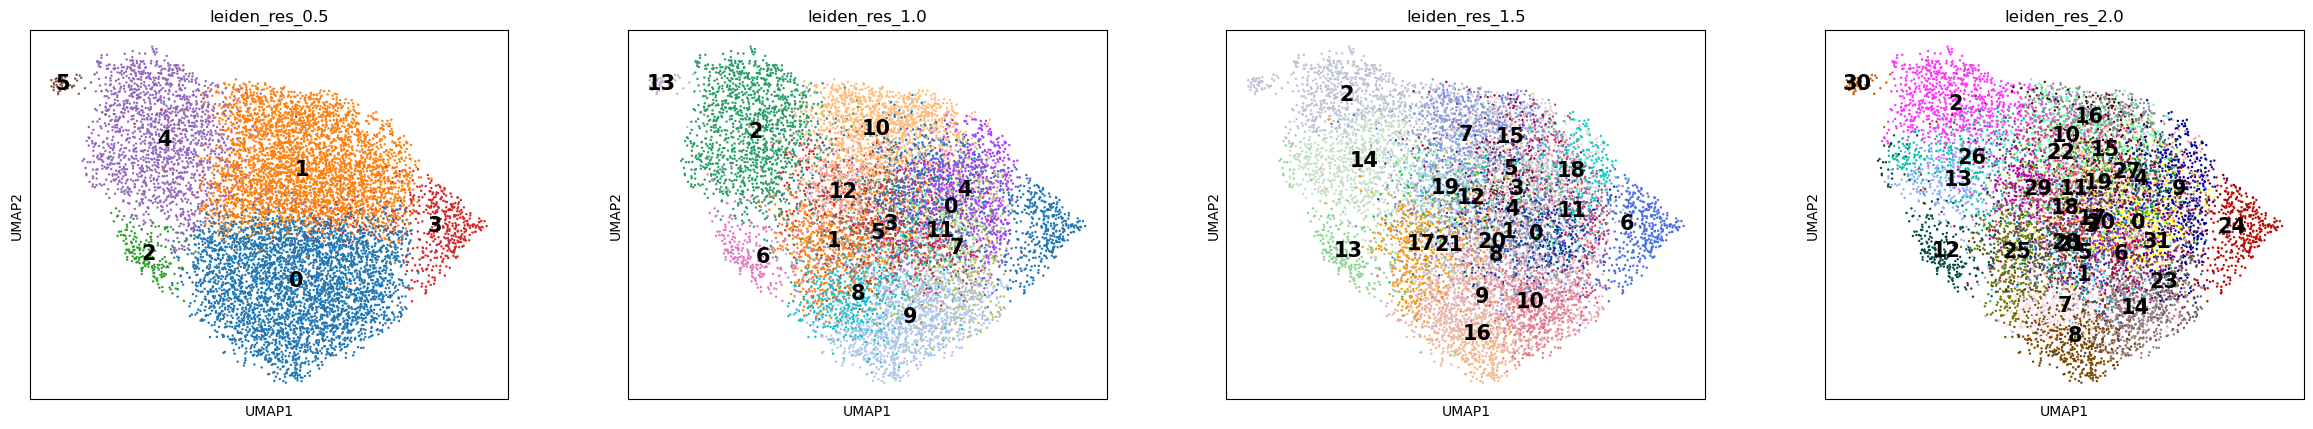

In [124]:
sc.pl.umap(
    adata_cd4,
    color=[ "leiden_res_0.5", "leiden_res_1.0","leiden_res_1.5", "leiden_res_2.0"],
    legend_loc="on data", legend_fontsize = 15
)

In [125]:
adata_cd4.write_h5ad("../../../write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster_2.h5ad", compression='gzip')
print(adata_cd4)

AnnData object with n_obs × n_vars = 9904 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_cd4_res_1_colors', 'cell_type_colors', 'hvg', 
'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'log1p', 'neighbors', 'pca', 
'pica_id_colors', 'rank_genes_groups', 'umap', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 
'leiden_res_1.5_colors', 'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

saving figure to file ../../../figures/PICA0001-PICA0007/02_annotation/dotplot__all_markers.png


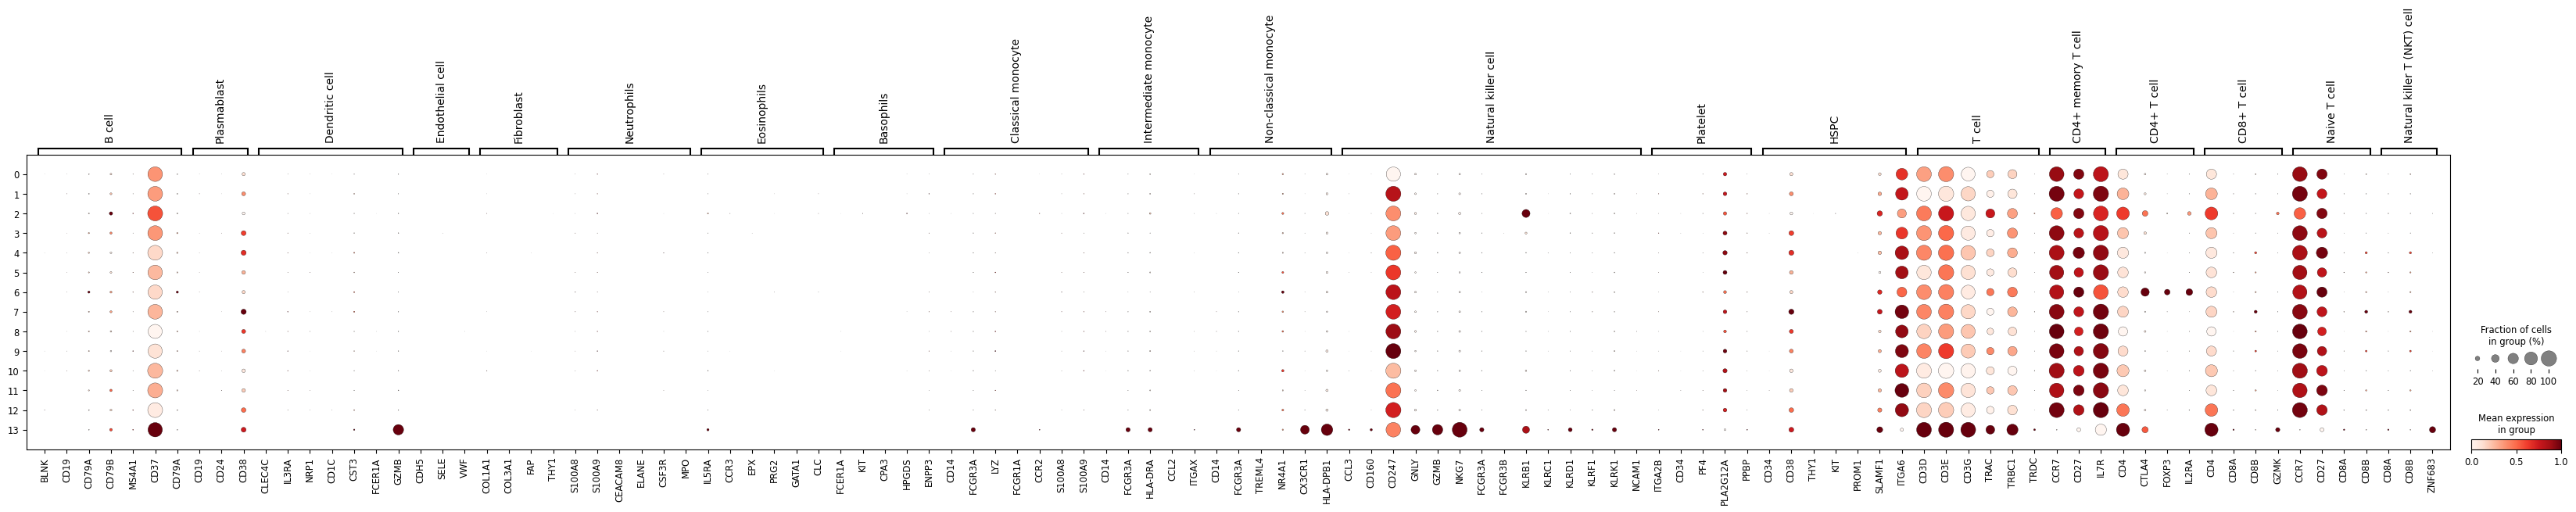

In [126]:
sc.pl.dotplot(adata_cd4, present_marker_genes , groupby="leiden_res_1.0", standard_scale="var", save="_all_markers.png")

Checking cluster 13

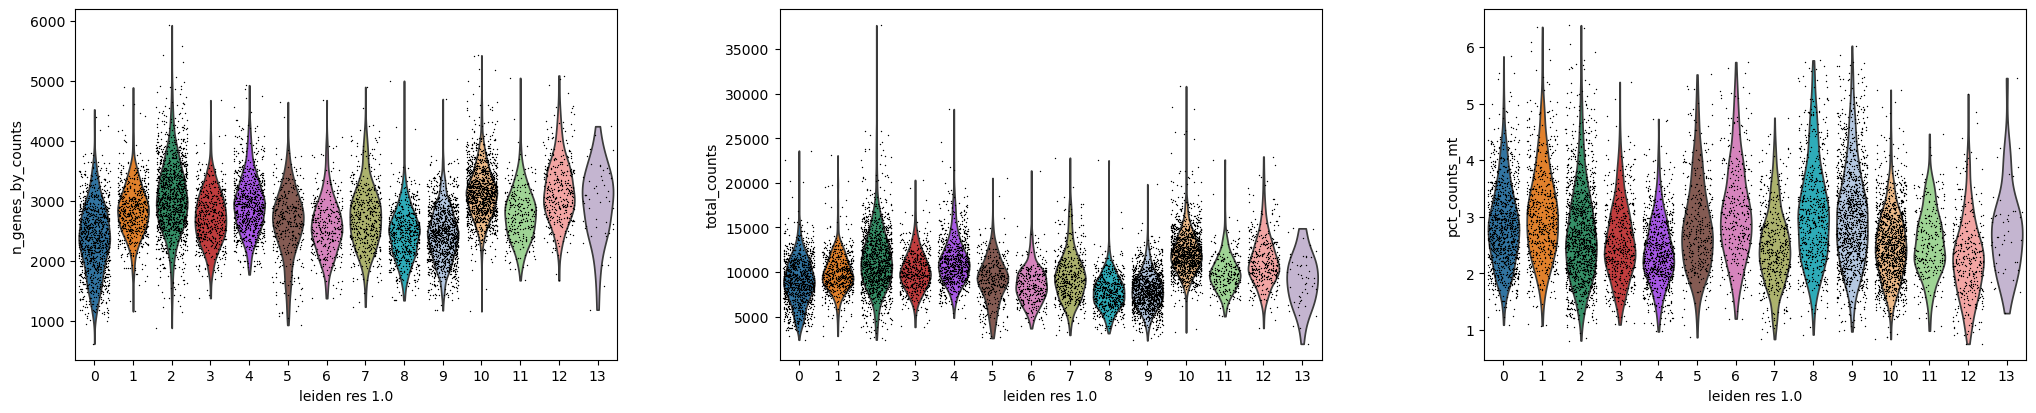

In [129]:
sc.pl.violin(adata_cd4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= 'leiden_res_1.0', jitter=0.4, multi_panel=True)

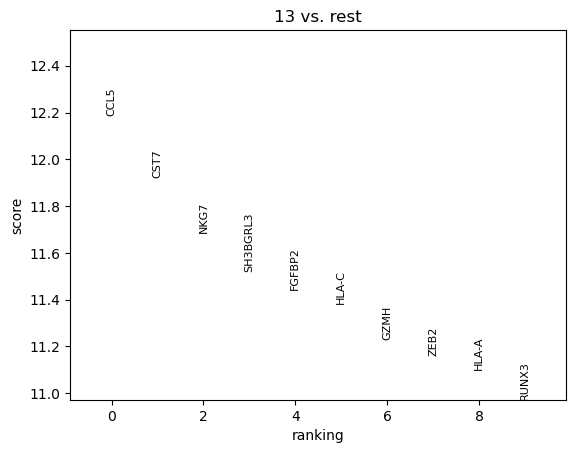

In [131]:
sc.tl.rank_genes_groups(adata_cd4, groupby="leiden_res_1.0", groups=['13'], method="wilcoxon")
sc.pl.rank_genes_groups(adata_cd4, groupby="leiden_res_1.0", n_genes=10)

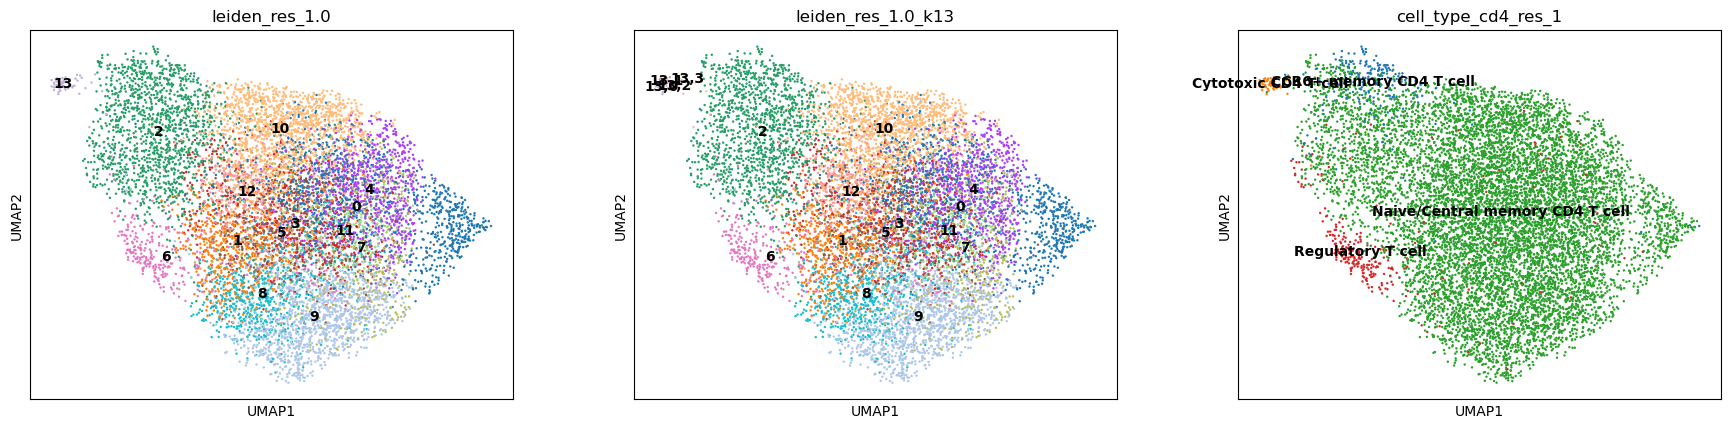

In [127]:
adata_cd4_k13 = adata_cd4.copy()
sc.tl.leiden(adata_cd4_k13, resolution=1.0, restrict_to=('leiden_res_1.0', ['13']), key_added='leiden_res_1.0_k13')
sc.pl.umap(adata_cd4_k13, color=['leiden_res_1.0', 'leiden_res_1.0_k13','cell_type_cd4_res_1'], legend_loc="on data")

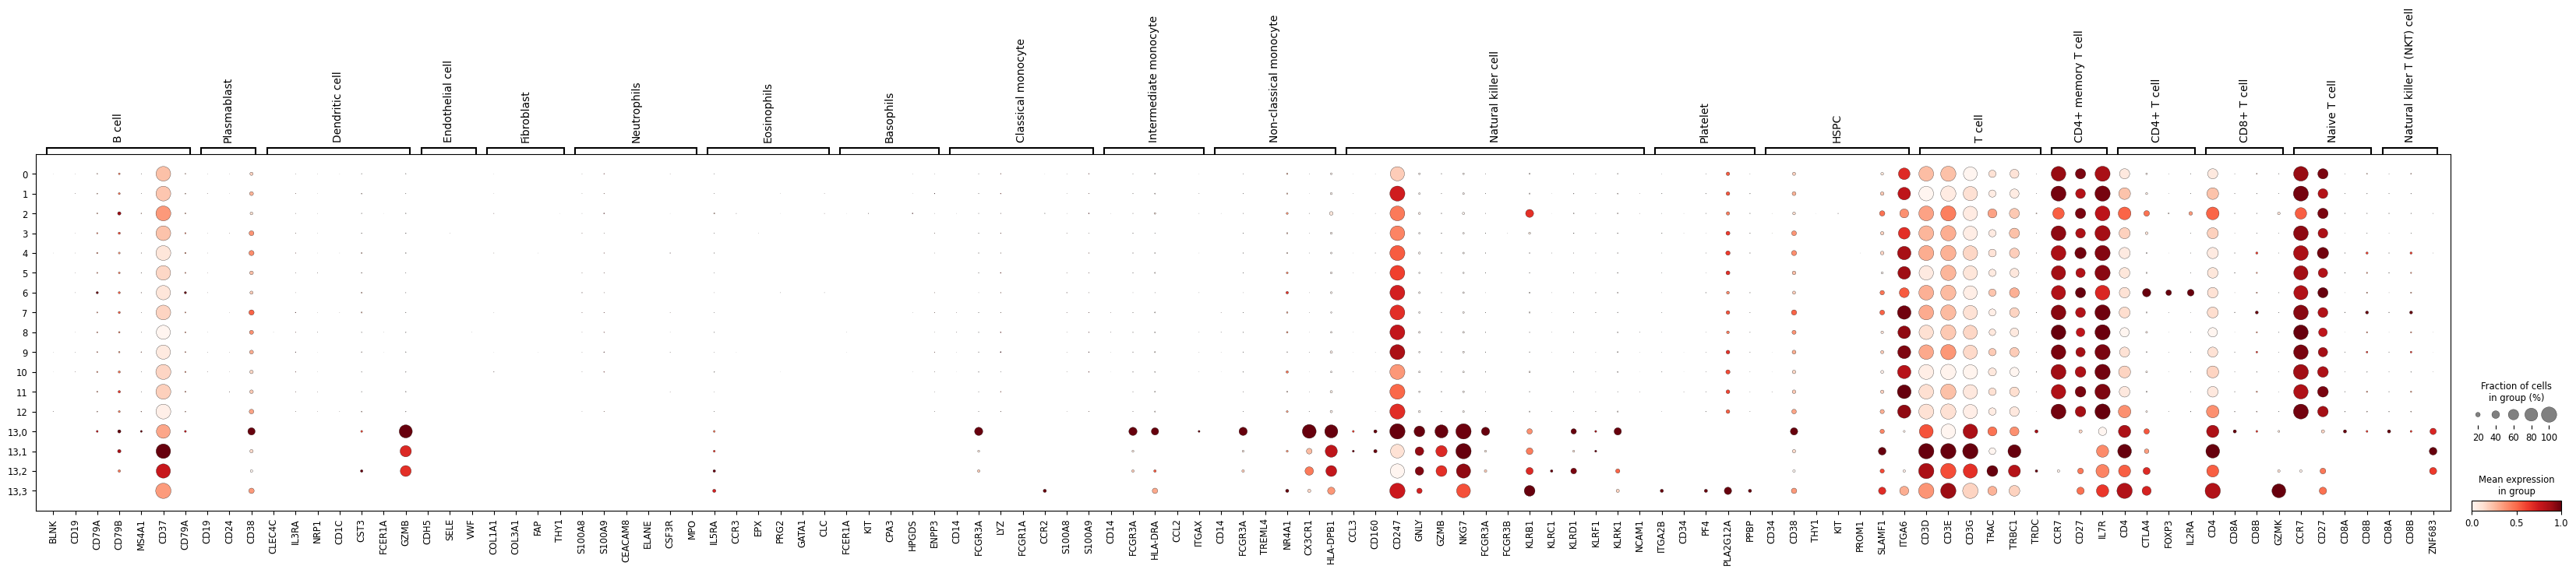

In [128]:
sc.pl.dotplot(adata_cd4_k13, present_marker_genes , groupby="leiden_res_1.0_k13", standard_scale="var")

Cluster 13 does not have CD19 markers, they showed NK markers --> cytotoxic CD4 t cells
We can keep cluster 13

In [130]:
adata_cd4.obs['cell_type_cd4_res_1'].value_counts()

cell_type_cd4_res_1
Naive/Central memory CD4 T cell    9373
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

In [133]:
adata_cd4.write_h5ad("../../../write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_cd4_annotations.h5ad", compression='gzip')
print(adata_cd4)

AnnData object with n_obs × n_vars = 9904 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_cd4_res_1_colors', 'cell_type_colors', 'hvg', 
'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'log1p', 'neighbors', 'pca', 
'pica_id_colors', 'rank_genes_groups', 'umap', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 
'leiden_res_1.5_colors', 'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'